In [115]:
import gspread
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from google.auth import default
from statsmodels.graphics.mosaicplot import mosaic
from scipy import stats
from sklearn.decomposition import PCA


class Analysis():

  def __init__(self, sheet_id, sheet_name, auto_proc=True, to_drop=[]):
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    wb = gc.open_by_key(sheet_id)
    sheet = wb.worksheet(sheet_name)
    self.data = sheet.get_all_values()
    self.df = self.load_df(self.data)
    self.df_full = None
    self.set_zh_font()
    if auto_proc:
      self.drop(to_drop)
      self.replace_0_to_NaN()
      self.convert_to_numeric()
      
  def load_df(self, data):
    df = pd.DataFrame(data)
    df.columns = df.loc[0, :].values.tolist()  # gsheet 預設欄位是數字 所以把第一行換成欄位/變數名
    df = df.drop([0]).reset_index()  # 去除一行多的東西 這個不一定要做 看你自己的資料 
    return df

  def info(self):
    self.df.info()

  def describe(self):
    self.df.describe()

  def cols(self):
    return self.df.columns.to_list()

  def print_cols(self):
    for i, c in enumerate(self.cols()):
      print(i, c)

  def drop(self, columns_array):
    self.df_full = self.df.copy(deep=True)
    self.df = self.df.drop(columns_array, axis=1)

  def replace_0_to_NaN(self):
    for col in self.df.columns:
      self.df[col] = self.df[col].apply(
        lambda x: np.nan if x == 0 else x)

  def replace_empty_str_to_NaN(self):
    for col in self.df.columns:
      self.df[col] = self.df[col].apply(
        lambda x: np.nan if x == '' else x)

  def binary_converter(self, col):
    # convert 1/2 binary to 1/0
    # 1 = Yes
    # 2 = No (should be 0)
    self.df[col] = self.df[col].apply(lambda x: 0 if x == 2 else x)

  def print_value_counts(self):
    print(len(self.df.columns))
    print(self.df.columns)
    for i in self.df.columns:
      print(i)
      print(self.df[i].value_counts())
      print("---------------------------------")

  def convert_to_numeric(self):
    for i in range(0, len(self.df.columns)):
      self.df.iloc[:,i] = pd.to_numeric(
        self.df.iloc[:,i], errors='coerce')

  def print_dtypes(self):
    print(self.df.dtypes)

  def set_zh_font(self):
    fm.fontManager.ttflist += fm.createFontList(['regular.ttf'])
    matplotlib.rc('font', family='Noto Sans TC')

In [ ]:
# download font
!wget http://qinghe.com.tw/fonts/Noto%20Sans%20TC/regular.ttf

In [116]:
a = Analysis('1Xhp7kQfweLOLmiAQpMgfVFuLnClL1kVEKuNDV5a6eTo', '5-Clean-Filter', to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [117]:
a.print_cols()

0 index
1 UUID
2 聲因1
3 聲因2
4 聲因3
5 聲因4
6 聲因5
7 聲因6
8 聲因7
9 聲因8
10 宣告性質
11 原監護輔助人之類型
12 原監護輔助人之人數（自然人）
13 主管機關是否被法院改定 (1=是, 2=否)
14 法院是否於聲請原因外考量「其他改定因素」
15 法院是否認為原監護輔助人「年事已高」
16 法院是否考慮原監護輔助人之身體狀況
17 法院是否認為原監護輔助人「身體不堪負荷」
18 法院是否認為原監護輔助人「盜領存款」
19 法院是否認為原監護輔助人「不當處理本人之不動產」
20 法院是否認為原監護輔助人「與本人有利害關係」
21 法院是否認為原監護輔助人有「其他不當行為」
22 法院是否認為原監護輔助人是「本人之實際照顧者」
23 原監護輔助人是否有意願續任
24 社工訪視報告之「改定建議」
25 家調官訪視報告之「改定建議」
26 本人之「改定建議」
27 其他親屬、關係人之「改定建議」
28 原監護輔助人是否被法院改定


In [118]:
class Corr(Analysis):

  def corr_heatmap(self):
    """4.1"""
    ## 檢查共線性
    colormap = plt.cm.viridis
    plt.figure(figsize=(20,16))
    plt.title('all corelations', y=1.05, size=15)
    corr = self.df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
      sns.heatmap(corr, linewidths=0.1, vmax=1.0,
                  square=True, cmap="YlGnBu",
                  linecolor='white', annot=True, mask=mask)

  def chi2_contingency_and_mosaic(self, column_a, column_b):
    """4.2"""
    crosstable = pd.crosstab(
        self.df[column_a],
        self.df[column_b])
    stat, p, dof, expected = stats.chi2_contingency(crosstable, correction=False)
    print(crosstable)
    # interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('兩者有關 Dependent (reject H0)')
    else:
        print('兩者無關 Independent (H0 holds true)')
    mosaic(self.df, [column_a, column_b])
    plt.show()

  def pca(self):
    """4.3.1"""
    # You must normalize the data before applying the fit method
    df_normalized=(self.df - self.df.mean()) / self.df.std()
    pca = PCA(n_components=self.df.shape[1])
    pca.fit(df_normalized)

    # Reformat and view results
    loadings = pd.DataFrame(
        pca.components_.T,
      columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
      index=self.df.columns)
    print(loadings)

    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance')
    plt.xlabel('Components')
    plt.show()

  def pca2(self, column_a, column_b):
    """4.3.2"""
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(self.df)
    principalDf = pd.DataFrame(data=principalComponents, columns=[column_a, column_b])
    finalDf = principalDf
    print(finalDf.head())

    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1)
    sns.scatterplot(x=column_a, y=column_b, data=finalDf)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


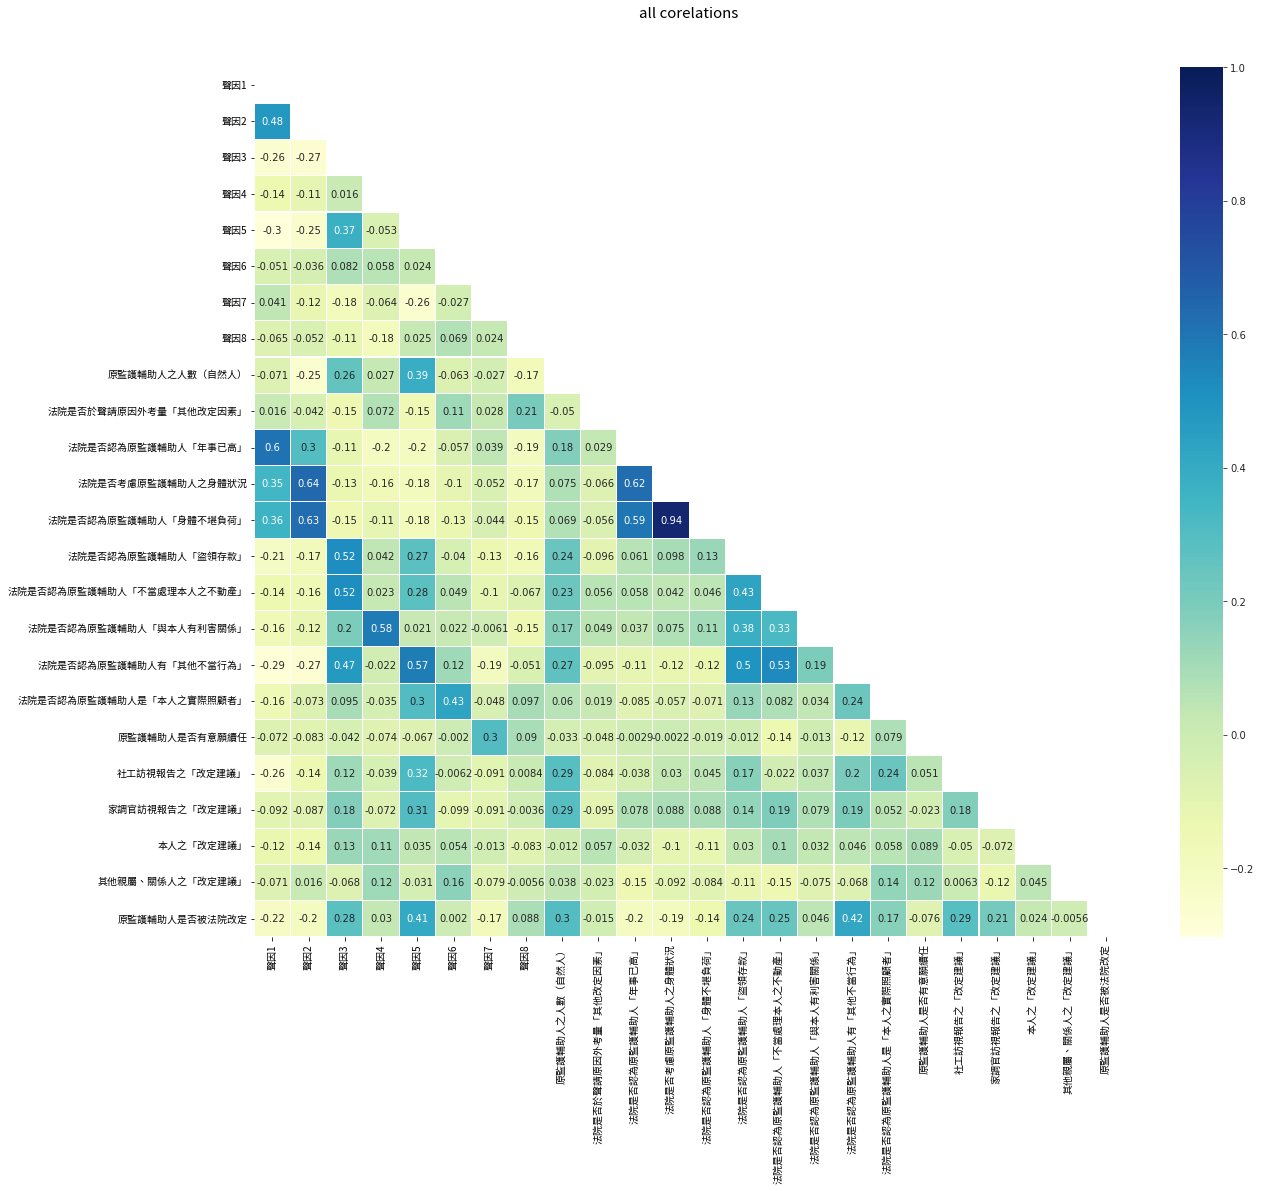

In [120]:
c = Corr('1Xhp7kQfweLOLmiAQpMgfVFuLnClL1kVEKuNDV5a6eTo', '5-Clean-Filter', to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
c.corr_heatmap()

原監護輔助人是否被法院改定    1   2
聲因1                   
0              121  76
1               56  10
p value is 0.0004459358196073799
兩者有關 Dependent (reject H0)


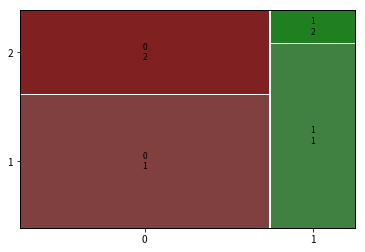

In [121]:
c.chi2_contingency_and_mosaic(c.cols()[0], c.cols()[23])

                               PC0       PC1       PC2       PC3       PC4  \
聲因1                      -0.297464  0.169177 -0.039145  0.008077 -0.144497   
聲因2                      -0.300455  0.220455 -0.081065  0.200520 -0.176064   
聲因3                       0.308532  0.153884  0.082583 -0.046887 -0.098301   
聲因4                       0.077929 -0.060924  0.528336  0.153762  0.076289   
聲因5                       0.328534  0.101463 -0.260806 -0.003101 -0.033377   
聲因6                       0.064745 -0.083193 -0.025016  0.587693 -0.067194   
聲因7                      -0.098948 -0.119121  0.074297 -0.143478  0.450103   
聲因8                       0.002112 -0.181638 -0.268906  0.075654 -0.132367   
原監護輔助人之人數（自然人）            0.192493  0.223636 -0.064570 -0.105727  0.270994   
法院是否於聲請原因外考量「其他改定因素」     -0.037200 -0.092339  0.113911  0.180695 -0.163559   
法院是否認為原監護輔助人「年事已高」       -0.211496  0.364563 -0.008855  0.020107  0.084567   
法院是否考慮原監護輔助人之身體狀況        -0.233983  0.433897 -0.039211  0.129690

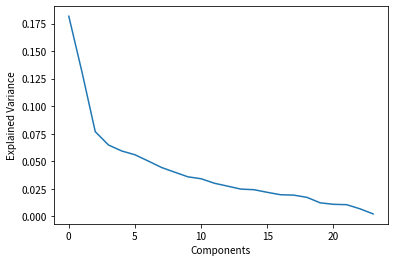

In [122]:
c.pca()

        聲因1  原監護輔助人是否被法院改定
0 -1.384401       2.716138
1  0.971267      -1.279322
2 -0.704590       0.932823
3  1.650461      -1.548179
4  1.405580      -0.103686


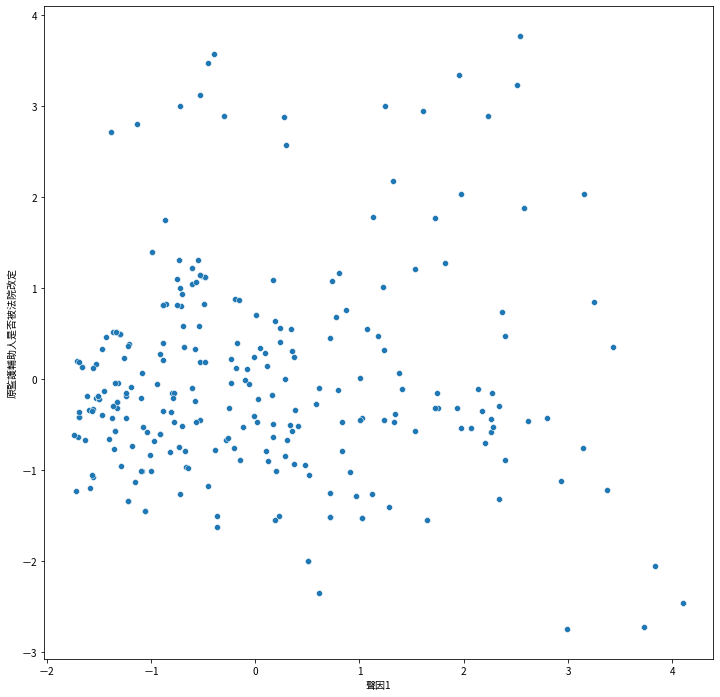

In [123]:
c.pca2(c.cols()[0], c.cols()[23])

In [111]:
import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import preprocessing, linear_model

class DecisionTree(Analysis):
  def load(self, columns_x, columns_y, binary_y):
    print('x', columns_x)
    print('y', columns_y)
    self.X = self.df[columns_x]
    self.y = self.df[columns_y]

    # 切分訓練與測試資料
    train_X, test_X, train_y, test_y = train_test_split(self.X, self.y, test_size = 0.2)

    if binary_y:
      lm = linear_model.LogisticRegression() # 如果是二元y
    else:
      lm = LinearRegression() # 如果是數值y

    # 建立分類器
    clf = tree.DecisionTreeClassifier(max_depth=3)
    self.my_clf = clf.fit(train_X, train_y)

    # 預測
    test_y_predicted = self.my_clf.predict(test_X)
    print(test_y_predicted)

    # 標準答案
    print(test_y.values)

    # 績效
    accuracy = metrics.accuracy_score(test_y, test_y_predicted)
    print(accuracy)
  
  def sort(self):
    return np.sort(self.y.unique()).astype(str).tolist()

  def text_representation(self):
    text_representation = tree.export_text(self.my_clf)
    print(text_representation)
  
  def graph(self):
    # DOT data
    dot_data = tree.export_graphviz(self.my_clf, out_file=None, 
                    feature_names=self.X.columns.tolist(),  
                    class_names=self.sort(),
                    filled=True)

    # Draw graph
    return graphviz.Source(dot_data) 
  
  def tree(self):
    fig = plt.figure(figsize=(16,16))
    return tree.plot_tree(self.my_clf, 
              feature_names=self.X.columns.tolist(),  
              class_names=np.sort(self.y.unique()).astype(str).tolist(),
              filled=True)

In [112]:
d = DecisionTree('1Xhp7kQfweLOLmiAQpMgfVFuLnClL1kVEKuNDV5a6eTo', '5-Clean-Filter', auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
d.binary_converter('原監護輔助人是否被法院改定')
d.load(d.cols()[0:8], d.cols()[23], binary_y=True)
d.text_representation()

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8']
y 原監護輔助人是否被法院改定
[1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1]
[1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1
 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1]
0.660377358490566
|--- feature_4 <= 0.50
|   |--- feature_3 <= 0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 1
|   |--- feature_3 >  0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_5 >  0.50
|   |   |   |--- class: 1
|--- feature_4 >  0.50
|   |--- feature_0 <= 0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_5 >  0.50
|   |   |   |--- class: 0
|   |--- feature_0 >  0.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_3 >  0.50
|   |   |   |--- class: 0



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


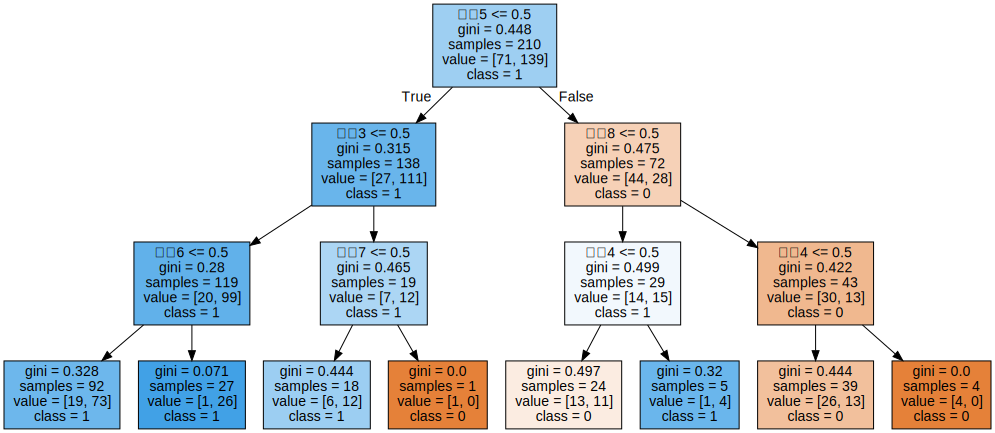

In [110]:
d.graph()

[Text(0.5, 0.875, '聲因5 <= 0.5\ngini = 0.431\nsamples = 210\nvalue = [66, 144]\nclass = 1'),
 Text(0.25, 0.625, '聲因4 <= 0.5\ngini = 0.276\nsamples = 139\nvalue = [23, 116]\nclass = 1'),
 Text(0.125, 0.375, '聲因2 <= 0.5\ngini = 0.233\nsamples = 119\nvalue = [16, 103]\nclass = 1'),
 Text(0.0625, 0.125, 'gini = 0.302\nsamples = 70\nvalue = [13, 57]\nclass = 1'),
 Text(0.1875, 0.125, 'gini = 0.115\nsamples = 49\nvalue = [3, 46]\nclass = 1'),
 Text(0.375, 0.375, '聲因6 <= 0.5\ngini = 0.455\nsamples = 20\nvalue = [7, 13]\nclass = 1'),
 Text(0.3125, 0.125, 'gini = 0.497\nsamples = 13\nvalue = [6, 7]\nclass = 1'),
 Text(0.4375, 0.125, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]\nclass = 1'),
 Text(0.75, 0.625, '聲因1 <= 0.5\ngini = 0.478\nsamples = 71\nvalue = [43, 28]\nclass = 0'),
 Text(0.625, 0.375, '聲因6 <= 0.5\ngini = 0.471\nsamples = 66\nvalue = [41, 25]\nclass = 0'),
 Text(0.5625, 0.125, 'gini = 0.487\nsamples = 50\nvalue = [29, 21]\nclass = 0'),
 Text(0.6875, 0.125, 'gini = 0.375\nsamples = 16

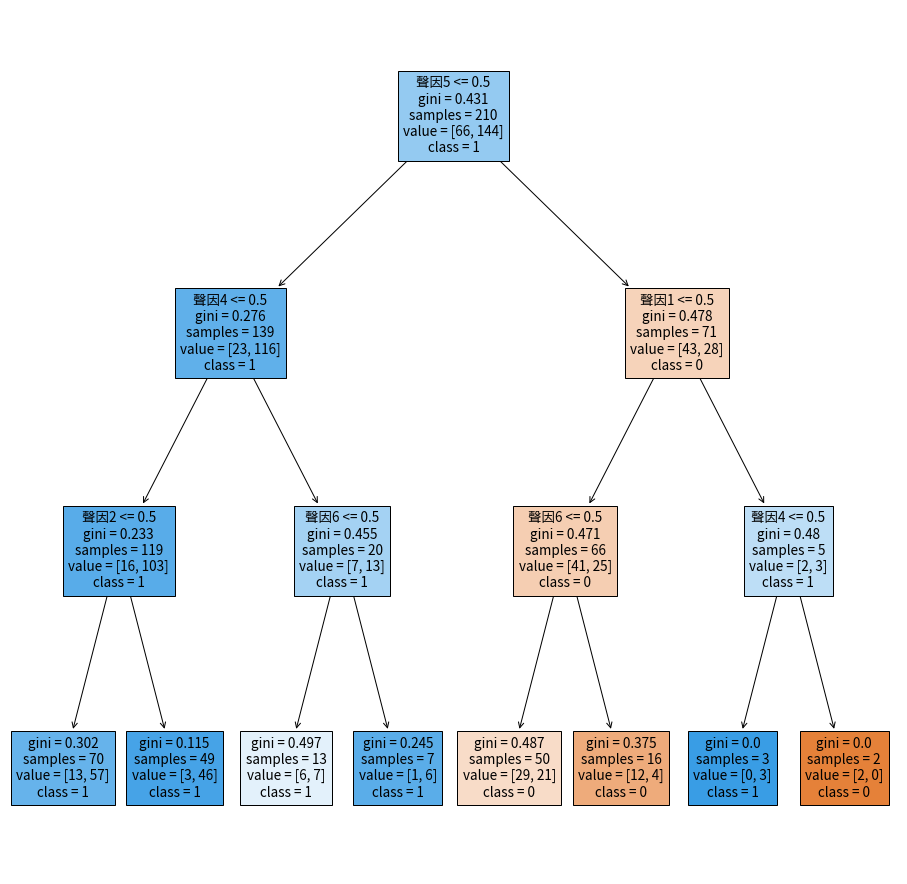

In [114]:
d.tree()

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import preprocessing, linear_model


class MultipleRegression(Analysis):
  def load(self, columns_x, columns_y, binary_y=False):
    print('x', columns_x)
    print('y', columns_y)
    self.X = self.df[columns_x]
    self.y = self.df[columns_y]

    if binary_y:
      self.lm = linear_model.LogisticRegression() # 如果是二元y
    else:
      self.lm = LinearRegression() # 如果是數值y

    self.lm.fit(self.X, self.y)

    # 項目
    print(self.X.columns)
    # 印出係數
    print(self.lm.coef_)
    # 印出 p-value
    print(f_regression(self.X, self.y)[1])
    # 印出截距
    print(self.lm.intercept_)

  def vars(self):
    # 模型績效
    mae = np.mean(abs(self.lm.predict(self.X) - self.y))
    mse = np.mean((self.lm.predict(self.X) - self.y) ** 2)
    r_squared = self.lm.score(self.X, self.y)
    adj_r_squared = r_squared - (1 - r_squared) * (self.X.shape[1] / (self.X.shape[0] - self.X.shape[1] - 1))

    # 印出模型績效
    print('mae:', mae) # 越小越好 單位就是y的單位
    print('mse:', mse) # 越小越好 單位就是y的單位
    print('r2:', r_squared) # 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這附近） 0.5以下（整個歪了）
    print('adj_r2:', adj_r_squared)  # 各係數標準化後的r2 越大越好 模型適配程度 0.75以上好（可以畢業了） 0.5以上堪用（現實數據常常在這

  def predict(self, arr=[1, 1, 1, 1, 0, 0, 0, 0]):
    to_be_predicted = np.array([arr])
    predicted_sales = self.lm.predict(to_be_predicted)

    # 預測
    print(predicted_sales)

In [142]:
m = MultipleRegression('1Xhp7kQfweLOLmiAQpMgfVFuLnClL1kVEKuNDV5a6eTo', '5-Clean-Filter', auto_proc=True, to_drop=[
  'index',
  'UUID',
  '主管機關是否被法院改定 (1=是, 2=否)',
  '宣告性質',
  '原監護輔助人之類型'
])
m.load(m.cols()[0:8], m.cols()[23])
m.vars()
m.predict()

x ['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8']
y 原監護輔助人是否被法院改定
Index(['聲因1', '聲因2', '聲因3', '聲因4', '聲因5', '聲因6', '聲因7', '聲因8'], dtype='object')
[-0.04401362 -0.07459466  0.14556389  0.0661994   0.30786654 -0.03480396
 -0.11204649  0.09772593]
[4.05299580e-04 1.02756134e-03 3.76016380e-06 6.32930692e-01
 4.77028419e-12 9.73962329e-01 4.74507094e-03 1.53363789e-01]
1.1696724518872035
mae: 0.3472495919959771
mse: 0.17362479599798875
r2: 0.2110462807525375
adj_r2: 0.18619734471324734
[1.26282746]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
